In [8]:
import glob
import pandas as pd
import pickle as pk
import numpy as np

import vtils
from vtils import getnormdis

# This path leads to a result of a previous training process. See that of yours 
# by changing this path to the dump path corresponding your training process.
preview_dump = 'dump/valid_*'

dumplist = glob.glob(preview_dump)
x_tick_gen = range(0, 300, 10)

valids = pd.DataFrame.from_dict({'valids': dumplist})
valids['epoch'] = valids['valids'].apply(lambda x: int(x.split('_')[-2]))
valids['batch'] = valids['valids'].apply(lambda x: int(x.split('_')[-1][:-3]))

In [9]:
valids

,valids,epoch,batch
0,dump/valid_p0_test_40_16.pk,40,16
1,dump/valid_p0_test_40_8.pk,40,8
2,dump/valid_p5_test_20_12.pk,20,12
3,dump/valid_p0_test_40_5.pk,40,5
4,dump/valid_p7_test_0_11.pk,0,11
5,dump/valid_p5_test_20_16.pk,20,16
6,dump/valid_p5_test_20_11.pk,20,11
7,dump/valid_p0_test_40_9.pk,40,9
8,dump/valid_p0_test_40_12.pk,40,12
9,dump/valid_p0_test_40_10.pk,40,10


In [12]:
arr[2].shape

(32, 19, 64, 32)

Text(0.5, 1.0, 'pd')

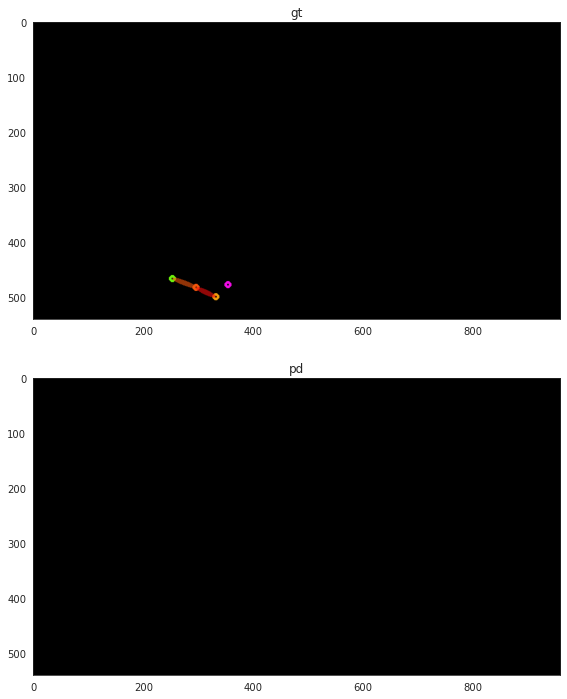

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from vtils import getkpt, pose, ncolors

colors = ncolors(19)[0]
colors[18] = np.array([0, 0, 0])

idx = 0
kptidx = 10
w, h = 32, 64

fig, ax = plt.subplots(2, 1, figsize=(10, 12))
sns.set_style('white')

arr = pk.load(open(valids.iloc[-1]['valids'], 'rb'))
realkpts, fakekpts = getkpt(arr, idx, 0, w, h, False)
canvas = np.zeros((960, 540, 3)).astype(np.uint8)
c0 = pose(canvas, realkpts, colors=colors)
canvas = np.zeros((960, 540, 3)).astype(np.uint8)
c1 = pose(canvas, fakekpts, colors=colors)

ax[0].imshow(c0.transpose((1, 0, 2)))
ax[1].imshow(c1.transpose((1, 0, 2)))
ax[0].set_title('gt')
ax[1].set_title('pd')

In [15]:
allnormacrossepoch = list()

for j in x_tick_gen:

    focus = valids[valids['epoch'] == j].sort_values('batch')

    import tqdm
    import pickle as pk

    allnormdist = list()

    for i in tqdm.trange(len(focus)):
        
        arr = pk.load(open(focus.iloc[i]['valids'], 'rb'))
        normdislist = getnormdis(arr, w=32, h=64)
        
        allnormdist.extend(normdislist)
        
    allnormacrossepoch.append(allnormdist)

100%|██████████| 19/19 [00:05<00:00,  3.60it/s]
0it [00:00, ?it/s]
100%|██████████| 19/19 [00:05<00:00,  3.56it/s]
0it [00:00, ?it/s]
100%|██████████| 19/19 [00:00<00:00, 26.81it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


/tmp/ipykernel_1733576/3442946937.py:7: RuntimeWarning: invalid value encountered in true_divide
  pck = dict(zip(['%.2f' % _ for _ in normthres], list((np.expand_dims(np.array(epochresult), 0) < (1 - normthresarr)).sum(1) / len(epochresult))))


Text(69.0, 0.5, 'PCK@')

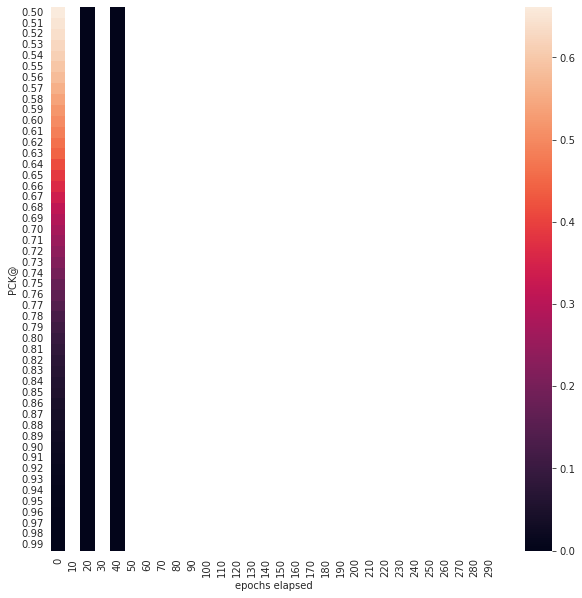

In [16]:
normthres = [(50 + i) / 100 for i in range(50)]
normthresarr = np.expand_dims(np.array(normthres), 1)

pcklist = list()

for epochresult in allnormacrossepoch:
    pck = dict(zip(['%.2f' % _ for _ in normthres], list((np.expand_dims(np.array(epochresult), 0) < (1 - normthresarr)).sum(1) / len(epochresult))))
    
    pcklist.append(np.array(list(pck.values())))
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

x_tick = list(x_tick_gen)
y_tick = ['%.2f' % _ for _ in normthres]

df = pd.DataFrame(np.stack(pcklist).transpose(), index=y_tick, columns=x_tick)
sns.heatmap(data=df, square=False)

label_y = ax.get_yticklabels()
plt.setp(label_y, rotation = 360)

ax.set_xlabel('epochs elapsed')
ax.set_ylabel('PCK@')

/tmp/ipykernel_1733576/2389885106.py:10: RuntimeWarning: invalid value encountered in true_divide
  pck = dict(zip(['%.2f' % _ for _ in normthres], list((np.expand_dims(np.array(epochresult), 0) < (1 - normthresarr)).sum(1) / len(epochresult))))


(-0.03, 1.03)

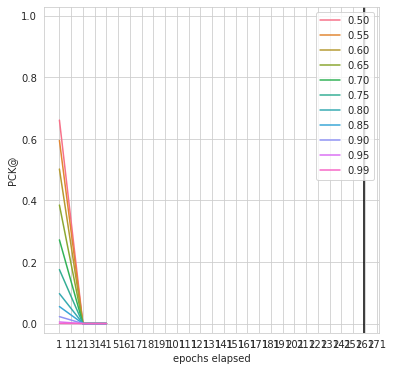

In [17]:
normthres = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
normthresarr = np.expand_dims(np.array(normthres), 1)

x_tick = [1 + _ for _ in list(x_tick_gen)]
y_tick = ['%.2f' % _ for _ in normthres]

pcklist = list()

for epochresult in allnormacrossepoch:
    pck = dict(zip(['%.2f' % _ for _ in normthres], list((np.expand_dims(np.array(epochresult), 0) < (1 - normthresarr)).sum(1) / len(epochresult))))
    
    pcklist.append(np.array(list(pck.values())))

sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

df = pd.DataFrame(np.stack(pcklist), columns=y_tick, index=x_tick)
sns.lineplot(data=df, dashes=False)
label_x = ax.get_xticklabels()

ax.set_xlabel('epochs elapsed')
ax.set_ylabel('PCK@')
ax.set_xticks(x_tick)

ax.vlines(260, -1, 2, 'black')

ax.set_ylim(-0.03, 1.03)

In [18]:
df.iloc[-1]

0.50   NaN
0.55   NaN
0.60   NaN
0.65   NaN
0.70   NaN
0.75   NaN
0.80   NaN
0.85   NaN
0.90   NaN
0.95   NaN
0.99   NaN
Name: 291, dtype: float64